In [ ]:
!pip3 install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [1]:
import urllib

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from PIL import Image
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

### Load Model

In [2]:
device=torch.device( "cuda" if (torch.cuda.is_available()) else 'cpu')
device

device(type='cuda')

In [3]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True).eval()
#model = model.to(device).eval()

Using cache found in C:\Users\Alok Suresh/.cache\torch\hub\pytorch_vision_v0.10.0


### Load raw images

In [15]:
input_image = Image.open(r'C:\Users\Alok Suresh\Desktop\PersonalProjects\StyleTransfer\images\me.jpg')
#input_image

In [18]:
style_image_raw = Image.open(r'C:\Users\Alok Suresh\Desktop\PersonalProjects\StyleTransfer\images\galaxy_art.jfif')
#style_image_raw

### Prepare content, style & generated images

In [19]:
def init_generated_img(tensor_shape): 
    return torch.rand(tensor_shape)      

to_pil = transforms.ToPILImage()

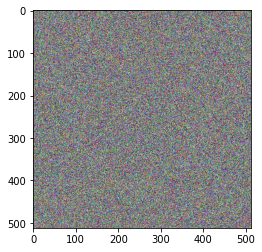

In [20]:
generated_image = init_generated_img((3, 512, 512))
plt.imshow(to_pil(generated_image).convert("RGB"))

In [21]:
process2 = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

content_image = process2(input_image)
content_image.size()

torch.Size([3, 512, 512])

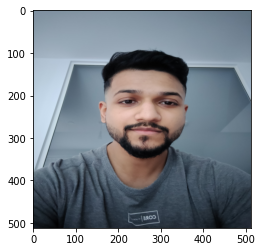

In [22]:
plt.imshow(to_pil(content_image).convert("RGB"))

In [23]:
style_image = process2(style_image_raw)
style_image.size()

torch.Size([3, 512, 512])

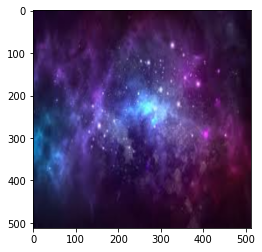

In [24]:
plt.imshow(to_pil(style_image).convert("RGB"))

In [25]:
# content_image = content_image.to(device, torch.float)
# style_image = style_image.to(device, torch.float)
# generated_image = generated_image.to(device, torch.float)

### Define cost functions

In [26]:
def content_cost_function(content_img_act, gen_img_act):
    return 0.5*squared_error(gen_img_act, content_img_act)

In [27]:
def style_cost_function(layer_activations):
    total_style_loss = 0
    layer_weights = [1.0, 0.8, 0.4, 0.2, 0.1]

    for idx, (layer, activations) in enumerate(layer_activations.items()):
        layer_style_loss = layer_weights[idx]*get_layer_style_loss(
            activations["style"], activations["gen"]
        )

        total_style_loss += layer_style_loss 
    
    return total_style_loss

def get_layer_style_loss(style_layer_activations, gen_layer_activations):
    scaling_constant = 1/(4*(style_layer_activations.size()[0]**2)*(style_layer_activations.size()[1]**2))
    style_gram_matrix = gram_matrix(style_layer_activations)
    gen_gram_matrix = gram_matrix(gen_layer_activations)

    return scaling_constant*squared_error(gen_gram_matrix, style_gram_matrix)

def gram_matrix(layer_activations): 
    return torch.mm(layer_activations, torch.transpose(layer_activations, 0 ,1))

def squared_error(preds, target): 
    return torch.sum(
        torch.square(preds - target)
    )


In [77]:
def style_transfer_cost_function(layer_activations, content_loss_layer=20):
    content_loss = content_cost_function(
        layer_activations[content_loss_layer]["content"],
        layer_activations[content_loss_layer]["gen"]
    )
    style_loss = style_cost_function(layer_activations)
    
    
    return 0.001*content_loss + 10000*style_loss

### Test cost functions

In [78]:
def construct_layer_activations(extraction_layers, gen_image):
    layer_activations = {}
    for layer in extraction_layers: 
        current_layer_activations = {
            "content": get_vgg_features(content_image, layer),
            "style": get_vgg_features(style_image, layer),
            "gen": get_vgg_features(gen_image, layer)
        }
        
        layer_activations[layer] = current_layer_activations
        
    return layer_activations
    
def get_vgg_features(input_tensor, extraction_layer): 
    input_batch = input_tensor.unsqueeze(0)
    
    output = model.features[:extraction_layer](input_batch).squeeze()
    
    return torch.reshape(output, (output.size()[0], output.size()[1]**2))

In [79]:
extraction_layers = [1, 6, 11, 20, 29]

In [80]:
test_layer_activations = construct_layer_activations(
    extraction_layers,
    generated_image
)

#### Content Loss

In [81]:
content_cost_function(
    test_layer_activations[20]["content"],
    test_layer_activations[20]["gen"], 
)

tensor(4021549.5000, grad_fn=<MulBackward0>)

#### Style Loss

In [82]:
style_cost_function(test_layer_activations)

tensor(2.8828, grad_fn=<AddBackward0>)

#### Style transfer loss

In [83]:
style_transfer_cost_function(test_layer_activations)

tensor(32849.4648, grad_fn=<AddBackward0>)

### Generate Image

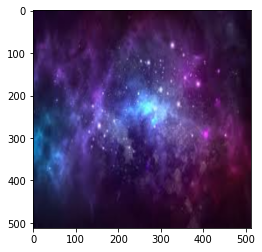

In [84]:
#generated_image = init_generated_img((3, 512, 512))
generated_image = style_image.clone().requires_grad_(True)
plt.imshow(to_pil(generated_image).convert("RGB"))

Epoch: 0, Loss: 21292.53125


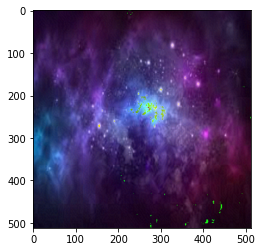

Epoch: 1, Loss: 20302.8125
Epoch: 2, Loss: 17299.64453125
Epoch: 3, Loss: 15884.427734375
Epoch: 4, Loss: 14416.775390625
Epoch: 5, Loss: 13613.291015625
Epoch: 6, Loss: 12738.0458984375
Epoch: 7, Loss: 12172.8974609375
Epoch: 8, Loss: 11732.451171875
Epoch: 9, Loss: 11346.046875
Epoch: 10, Loss: 11022.1865234375


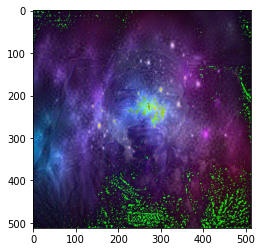

Epoch: 11, Loss: 10748.2578125
Epoch: 12, Loss: 10505.357421875
Epoch: 13, Loss: 10283.009765625
Epoch: 14, Loss: 10081.1552734375
Epoch: 15, Loss: 9894.095703125
Epoch: 16, Loss: 9719.18359375
Epoch: 17, Loss: 9554.06640625
Epoch: 18, Loss: 9398.5185546875
Epoch: 19, Loss: 9254.6904296875
Epoch: 20, Loss: 9118.9052734375


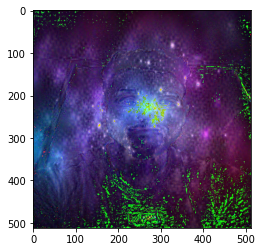

Epoch: 21, Loss: 8990.0625
Epoch: 22, Loss: 8868.396484375
Epoch: 23, Loss: 8754.5732421875
Epoch: 24, Loss: 8647.400390625
Epoch: 25, Loss: 8545.482421875
Epoch: 26, Loss: 8448.919921875
Epoch: 27, Loss: 8357.1142578125
Epoch: 28, Loss: 8270.162109375
Epoch: 29, Loss: 8187.3310546875
Epoch: 30, Loss: 8108.978515625


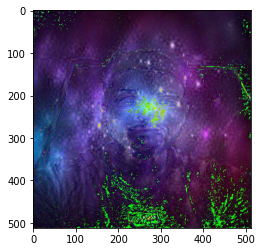

Epoch: 31, Loss: 8034.9541015625
Epoch: 32, Loss: 7965.1279296875
Epoch: 33, Loss: 7899.572265625
Epoch: 34, Loss: 7837.9794921875
Epoch: 35, Loss: 7779.6474609375
Epoch: 36, Loss: 7724.68359375
Epoch: 37, Loss: 7672.3095703125
Epoch: 38, Loss: 7622.61865234375
Epoch: 39, Loss: 7575.3076171875
Epoch: 40, Loss: 7530.0810546875


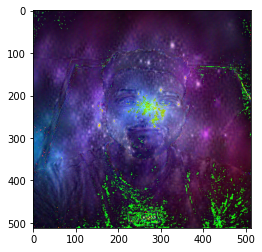

Epoch: 41, Loss: 7487.205078125
Epoch: 42, Loss: 7446.6298828125
Epoch: 43, Loss: 7407.7060546875
Epoch: 44, Loss: 7371.15185546875
Epoch: 45, Loss: 7335.82763671875
Epoch: 46, Loss: 7302.775390625
Epoch: 47, Loss: 7271.15283203125
Epoch: 48, Loss: 7242.30078125
Epoch: 49, Loss: 7213.4462890625
Epoch: 50, Loss: 7186.0283203125


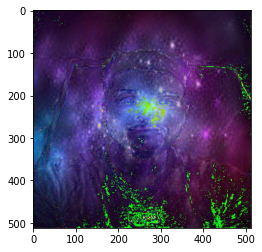

Epoch: 51, Loss: 7158.2724609375
Epoch: 52, Loss: 7131.7109375
Epoch: 53, Loss: 7105.396484375
Epoch: 54, Loss: 7081.78662109375
Epoch: 55, Loss: 7058.9658203125
Epoch: 56, Loss: 7036.82958984375
Epoch: 57, Loss: 7016.513671875
Epoch: 58, Loss: 6997.466796875
Epoch: 59, Loss: 6980.27685546875
Epoch: 60, Loss: 6964.6904296875


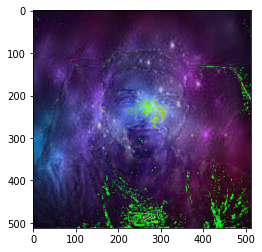

Epoch: 61, Loss: 6953.70068359375
Epoch: 62, Loss: 6940.8505859375
Epoch: 63, Loss: 6921.12158203125
Epoch: 64, Loss: 6897.8828125
Epoch: 65, Loss: 6879.8076171875
Epoch: 66, Loss: 6865.421875
Epoch: 67, Loss: 6852.53271484375
Epoch: 68, Loss: 6840.41015625
Epoch: 69, Loss: 6826.6337890625
Epoch: 70, Loss: 6813.78515625


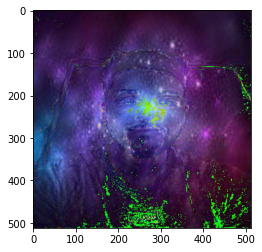

Epoch: 71, Loss: 6799.0234375
Epoch: 72, Loss: 6785.81298828125
Epoch: 73, Loss: 6772.3330078125
Epoch: 74, Loss: 6759.63427734375
Epoch: 75, Loss: 6747.02197265625
Epoch: 76, Loss: 6736.13232421875
Epoch: 77, Loss: 6724.89404296875
Epoch: 78, Loss: 6716.0830078125
Epoch: 79, Loss: 6709.0224609375
Epoch: 80, Loss: 6706.0087890625


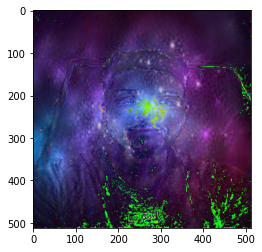

Epoch: 81, Loss: 6706.57421875
Epoch: 82, Loss: 6701.7001953125
Epoch: 83, Loss: 6687.8857421875
Epoch: 84, Loss: 6669.421875
Epoch: 85, Loss: 6654.06689453125
Epoch: 86, Loss: 6648.3701171875
Epoch: 87, Loss: 6644.484375
Epoch: 88, Loss: 6638.9619140625
Epoch: 89, Loss: 6631.51025390625
Epoch: 90, Loss: 6619.8828125


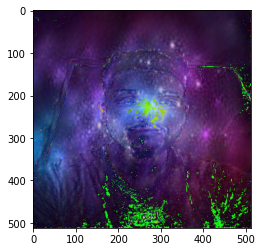

Epoch: 91, Loss: 6609.7373046875
Epoch: 92, Loss: 6597.140625
Epoch: 93, Loss: 6589.552734375
Epoch: 94, Loss: 6580.53173828125
Epoch: 95, Loss: 6572.7275390625
Epoch: 96, Loss: 6565.9912109375
Epoch: 97, Loss: 6560.24755859375
Epoch: 98, Loss: 6558.3310546875
Epoch: 99, Loss: 6565.06982421875
Epoch: 100, Loss: 6578.5810546875


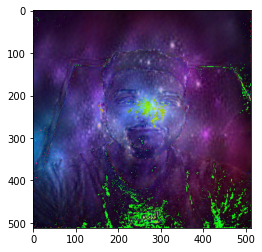

Epoch: 101, Loss: 6594.07763671875
Epoch: 102, Loss: 6570.3359375
Epoch: 103, Loss: 6538.6416015625
Epoch: 104, Loss: 6536.1279296875
Epoch: 105, Loss: 6537.9921875
Epoch: 106, Loss: 6534.546875
Epoch: 107, Loss: 6525.8369140625
Epoch: 108, Loss: 6509.7958984375
Epoch: 109, Loss: 6503.00439453125
Epoch: 110, Loss: 6496.02783203125


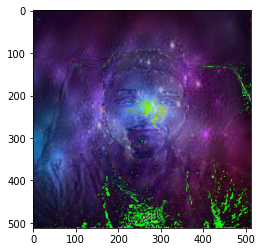

Epoch: 111, Loss: 6490.82470703125
Epoch: 112, Loss: 6488.228515625
Epoch: 113, Loss: 6484.6357421875
Epoch: 114, Loss: 6485.314453125
Epoch: 115, Loss: 6484.7880859375
Epoch: 116, Loss: 6481.15625
Epoch: 117, Loss: 6469.6953125
Epoch: 118, Loss: 6460.8818359375
Epoch: 119, Loss: 6449.25830078125
Epoch: 120, Loss: 6444.3935546875


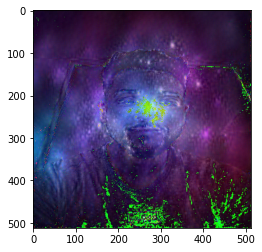

Epoch: 121, Loss: 6438.12109375
Epoch: 122, Loss: 6433.53271484375
Epoch: 123, Loss: 6432.37939453125
Epoch: 124, Loss: 6433.3203125
Epoch: 125, Loss: 6442.697265625
Epoch: 126, Loss: 6458.23046875
Epoch: 127, Loss: 6456.21533203125
Epoch: 128, Loss: 6437.9404296875
Epoch: 129, Loss: 6421.8232421875
Epoch: 130, Loss: 6412.2900390625


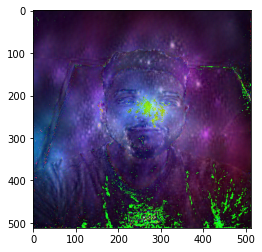

Epoch: 131, Loss: 6414.998046875
Epoch: 132, Loss: 6415.8544921875
Epoch: 133, Loss: 6410.1748046875
Epoch: 134, Loss: 6404.75439453125
Epoch: 135, Loss: 6392.01904296875
Epoch: 136, Loss: 6387.4091796875
Epoch: 137, Loss: 6378.42919921875
Epoch: 138, Loss: 6373.97265625
Epoch: 139, Loss: 6368.31103515625
Epoch: 140, Loss: 6363.30615234375


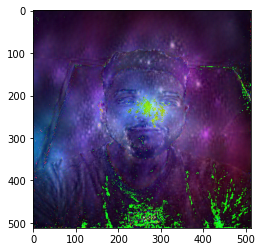

Epoch: 141, Loss: 6359.642578125
Epoch: 142, Loss: 6356.9150390625
Epoch: 143, Loss: 6361.16357421875
Epoch: 144, Loss: 6379.01416015625
Epoch: 145, Loss: 6404.21142578125
Epoch: 146, Loss: 6431.3828125
Epoch: 147, Loss: 6394.03759765625
Epoch: 148, Loss: 6358.017578125
Epoch: 149, Loss: 6367.01953125
Epoch: 150, Loss: 6372.68603515625


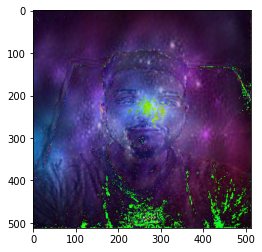

Epoch: 151, Loss: 6367.0244140625
Epoch: 152, Loss: 6359.478515625
Epoch: 153, Loss: 6341.65869140625
Epoch: 154, Loss: 6338.716796875
Epoch: 155, Loss: 6334.55712890625
Epoch: 156, Loss: 6330.9267578125
Epoch: 157, Loss: 6330.8798828125
Epoch: 158, Loss: 6327.47802734375
Epoch: 159, Loss: 6327.26416015625
Epoch: 160, Loss: 6324.2216796875


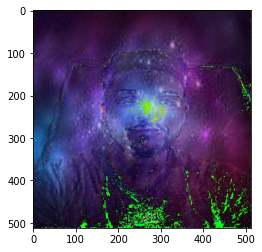

Epoch: 161, Loss: 6321.8134765625
Epoch: 162, Loss: 6314.1728515625
Epoch: 163, Loss: 6308.51953125
Epoch: 164, Loss: 6300.14990234375
Epoch: 165, Loss: 6295.6181640625
Epoch: 166, Loss: 6289.4873046875
Epoch: 167, Loss: 6286.3896484375
Epoch: 168, Loss: 6281.48388671875
Epoch: 169, Loss: 6279.3779296875
Epoch: 170, Loss: 6277.95947265625


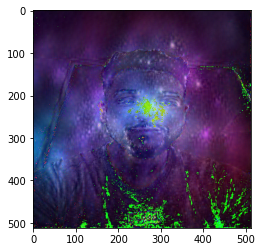

Epoch: 171, Loss: 6283.8681640625
Epoch: 172, Loss: 6301.6025390625
Epoch: 173, Loss: 6323.912109375
Epoch: 174, Loss: 6343.6484375
Epoch: 175, Loss: 6315.3916015625
Epoch: 176, Loss: 6282.09814453125
Epoch: 177, Loss: 6288.78173828125
Epoch: 178, Loss: 6290.9248046875
Epoch: 179, Loss: 6289.494140625
Epoch: 180, Loss: 6285.876953125


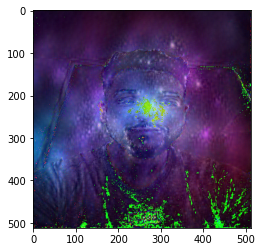

Epoch: 181, Loss: 6271.3837890625
Epoch: 182, Loss: 6269.1787109375
Epoch: 183, Loss: 6260.91943359375
Epoch: 184, Loss: 6256.76416015625
Epoch: 185, Loss: 6253.6923828125
Epoch: 186, Loss: 6249.82470703125
Epoch: 187, Loss: 6250.720703125
Epoch: 188, Loss: 6253.58642578125
Epoch: 189, Loss: 6266.2841796875
Epoch: 190, Loss: 6286.17578125


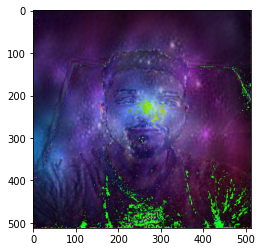

Epoch: 191, Loss: 6288.1181640625
Epoch: 192, Loss: 6269.8037109375
Epoch: 193, Loss: 6252.205078125
Epoch: 194, Loss: 6243.3544921875
Epoch: 195, Loss: 6250.5419921875
Epoch: 196, Loss: 6250.53076171875
Epoch: 197, Loss: 6245.619140625
Epoch: 198, Loss: 6243.20361328125
Epoch: 199, Loss: 6232.27783203125
Epoch: 200, Loss: 6229.1533203125


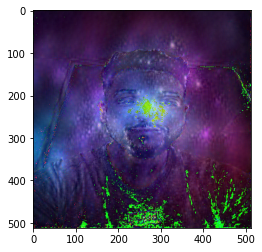

Epoch: 201, Loss: 6221.4296875
Epoch: 202, Loss: 6217.63623046875
Epoch: 203, Loss: 6213.8603515625
Epoch: 204, Loss: 6209.79931640625
Epoch: 205, Loss: 6206.1259765625
Epoch: 206, Loss: 6202.033203125
Epoch: 207, Loss: 6198.517578125
Epoch: 208, Loss: 6195.35791015625
Epoch: 209, Loss: 6192.29052734375
Epoch: 210, Loss: 6190.13720703125


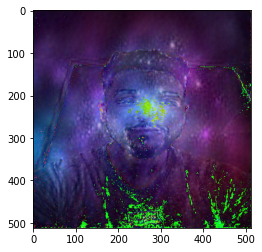

Epoch: 211, Loss: 6191.9306640625
Epoch: 212, Loss: 6206.83935546875
Epoch: 213, Loss: 6251.13330078125
Epoch: 214, Loss: 6354.23388671875
Epoch: 215, Loss: 6331.6025390625
Epoch: 216, Loss: 6257.4716796875
Epoch: 217, Loss: 6259.34814453125
Epoch: 218, Loss: 6270.71337890625
Epoch: 219, Loss: 6278.83349609375
Epoch: 220, Loss: 6269.94140625


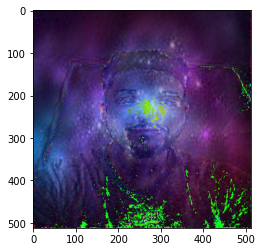

Epoch: 221, Loss: 6241.92626953125
Epoch: 222, Loss: 6241.30078125
Epoch: 223, Loss: 6235.533203125
Epoch: 224, Loss: 6229.37353515625
Epoch: 225, Loss: 6229.787109375
Epoch: 226, Loss: 6223.478515625
Epoch: 227, Loss: 6225.64501953125
Epoch: 228, Loss: 6221.9921875
Epoch: 229, Loss: 6223.95703125
Epoch: 230, Loss: 6215.58740234375


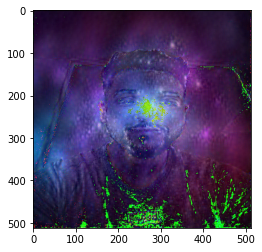

Epoch: 231, Loss: 6211.02197265625
Epoch: 232, Loss: 6197.3466796875
Epoch: 233, Loss: 6193.53271484375


KeyboardInterrupt: 

In [85]:
#generated_image = generated_image.requires_grad_(True)
optimiser = optim.Adam([generated_image], lr=0.01)
num_epochs = 3500

for epoch in range(num_epochs):
    layer_activations = construct_layer_activations(
        extraction_layers,
        generated_image
    )
     
    loss = style_transfer_cost_function(layer_activations)
    print(f"Epoch: {epoch}, Loss: {loss}")
     
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    if epoch % 10 == 0:
        plt.imshow(to_pil(generated_image).convert("RGB"))
        plt.show()

In [ ]:
plt.imshow(to_pil(generated_image).convert("RGB"))

In [ ]:
save_image(generated_image, "gen_1_512.png")